In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
train_path = "../input/wholesale/wholesale customers data.csv"

In [3]:
train = pd.read_csv(train_path)
train.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
region_map = {1:'Lisbon', 2:'Oporto', 3:'Other Region'}
channel_map = {1:'Horeca', 2:'Retail'}

train['Region'] = train['Region'].apply(lambda x: region_map[x])
train['Channel'] = train['Channel'].apply(lambda x: channel_map[x])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           440 non-null    object
 1   Region            440 non-null    object
 2   Fresh             440 non-null    int64 
 3   Milk              440 non-null    int64 
 4   Grocery           440 non-null    int64 
 5   Frozen            440 non-null    int64 
 6   Detergents_Paper  440 non-null    int64 
 7   Delicassen        440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


In [6]:
train.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [7]:
num_cols = train.select_dtypes(exclude=['object']).columns

max_abs = MaxAbsScaler()
max_abs_train = max_abs.fit_transform(train[num_cols])

std = StandardScaler()
std_train = std.fit_transform(train[num_cols])

In [8]:
def plot_inertia(data, clusters=range(1, 16)):
    inertia = []
    for k in clusters:
        kmean = KMeans(n_clusters=k, random_state=42)
        kmean.fit(data)
        inertia.append(kmean.inertia_)
    plt.figure(figsize=(10,5))
    plt.title('inertia for different no. of clusters')
    plt.xlabel('no. of clusters')
    plt.ylabel('inertia')
    plt.plot(clusters, inertia, marker='o')
    plt.show()

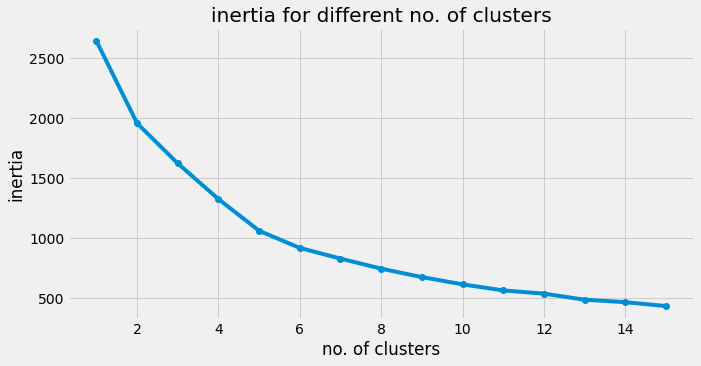

In [9]:
plot_inertia(std_train)

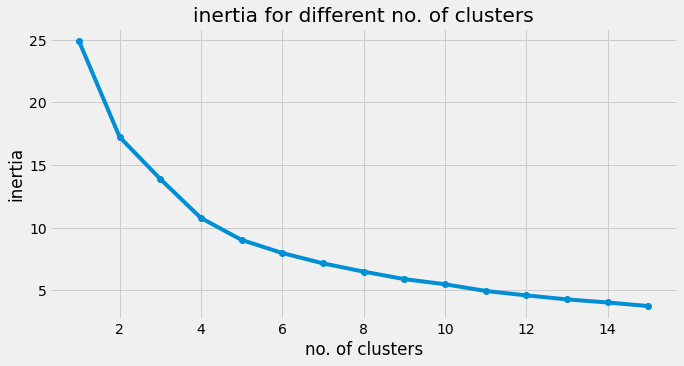

In [10]:
plot_inertia(max_abs_train)

In [11]:
kmean_abs = KMeans(n_clusters=4, random_state=42)
kmean_abs.fit(max_abs_train)
kmean_labels = pd.Series(kmean_abs.predict(max_abs_train), index=train.index)
kmean_abs.inertia_

10.761062555303115

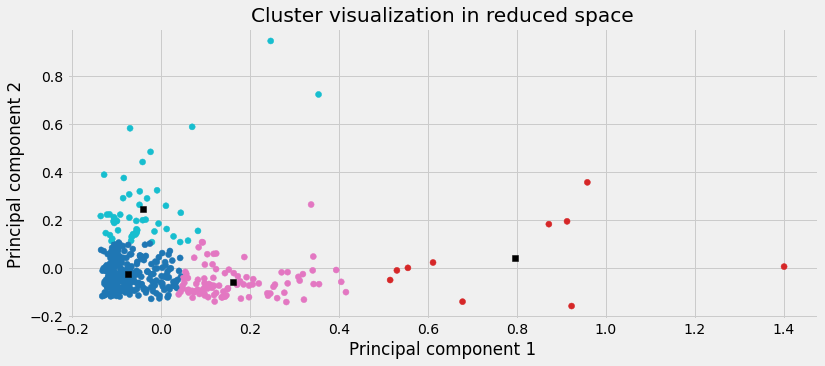

In [12]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(max_abs_train)
centers = pca.transform(kmean_abs.cluster_centers_)
plt.scatter(reduced[:,0], reduced[:,1],  c=kmean_labels, cmap='tab10')
plt.scatter(centers[:,0], centers[:,1], marker='s', c='black')
plt.title('Cluster visualization in reduced space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

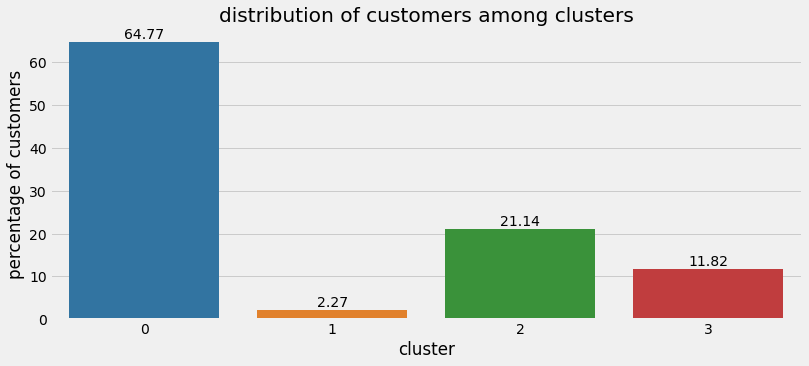

In [13]:
train['cluster'] = kmean_labels
cluster_counts = np.round(train['cluster'].value_counts(normalize=True) * 100, 2)
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts, palette='tab10')
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xlabel('cluster')
ax.set_ylabel('percentage of customers')
ax.set_title('distribution of customers among clusters')
plt.show()

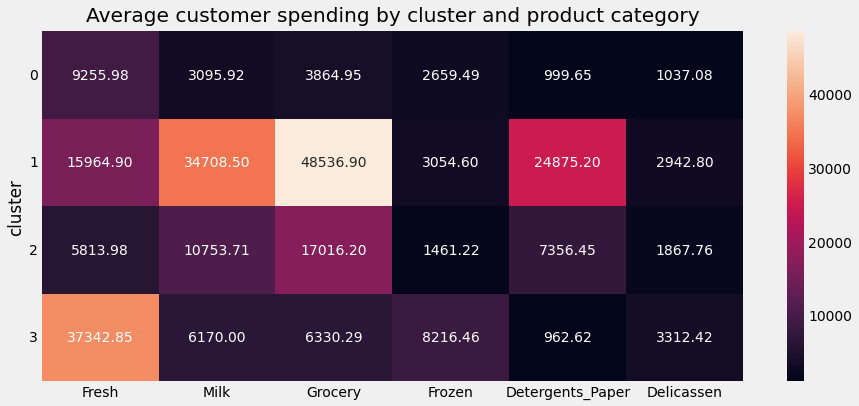

In [14]:
plt.figure(figsize=(14,6))
sns.heatmap(train.groupby('cluster').agg('mean'), annot=True, fmt='.2f')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Average customer spending by cluster and product category', pad=10)
plt.show()

based on the data, we could provide customers in cluster 0 and 2 better offers to try maintaining larger number of loyal customers

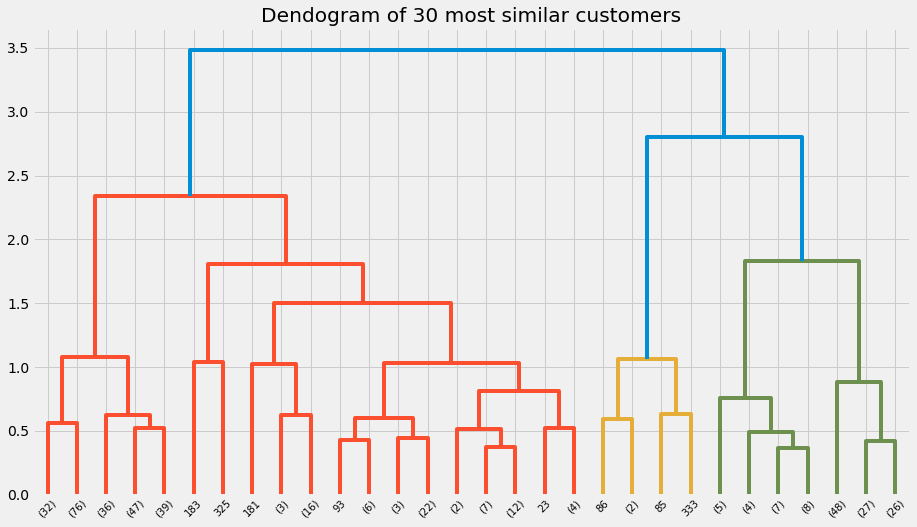

In [15]:
plt.figure(figsize=(14,8))
Z = linkage(max_abs_train, 'ward')
dn = dendrogram(Z, truncate_mode='lastp', p=30)
plt.title('Dendogram of 30 most similar customers')
plt.show()